# 1. Data Load

이제 제출을 해보겠습니다.

주어진 test데이터로 예측을 진행한 다음 sample_submission.csv에 예측한 값을 넣어보겠습니다.

앞서 train 셋에서 했던 동일한 전처리 과정을 거치되, data leakage가 발생하지 않도록 주의합니다.


In [17]:
import numpy as np
import pandas as pd
import os
import math
import random
from datetime import datetime

from scipy import stats #Analysis 
from scipy.stats import norm 
import pickle

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

import torch
from sklearn.model_selection import StratifiedKFold
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
path = "./Dataset/"

test = pd.read_csv(path+"train.csv")
test

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.0,5.0,5.0,5.0,1.0,4.0,5.0,5.0,1.0,...,1.0,20,2.0,12.0,4.0,2.0,1.0,4.0,2.0,1
1,1,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,...,1.0,49,1.0,2.0,1.0,1.0,2.0,4.0,2.0,1
2,2,4.0,5.0,5.0,4.0,3.0,5.0,5.0,5.0,4.0,...,2.0,43,1.0,2.0,2.0,2.0,3.0,4.0,2.0,1
3,3,4.0,4.0,4.0,2.0,4.0,3.0,3.0,5.0,3.0,...,1.0,17,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1
4,4,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,...,2.0,18,2.0,12.0,1.0,2.0,1.0,1.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2.0,5.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,...,1.0,17,1.0,1.0,3.0,2.0,1.0,3.0,2.0,0
14996,14996,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,...,2.0,45,1.0,3.0,1.0,1.0,2.0,3.0,2.0,1
14997,14997,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,1.0,20,1.0,1.0,2.0,1.0,1.0,3.0,1.0,1
14998,14998,5.0,5.0,4.0,5.0,5.0,5.0,5.0,1.0,5.0,...,1.0,29,1.0,12.0,4.0,2.0,2.0,2.0,1.0,0


<AxesSubplot:>

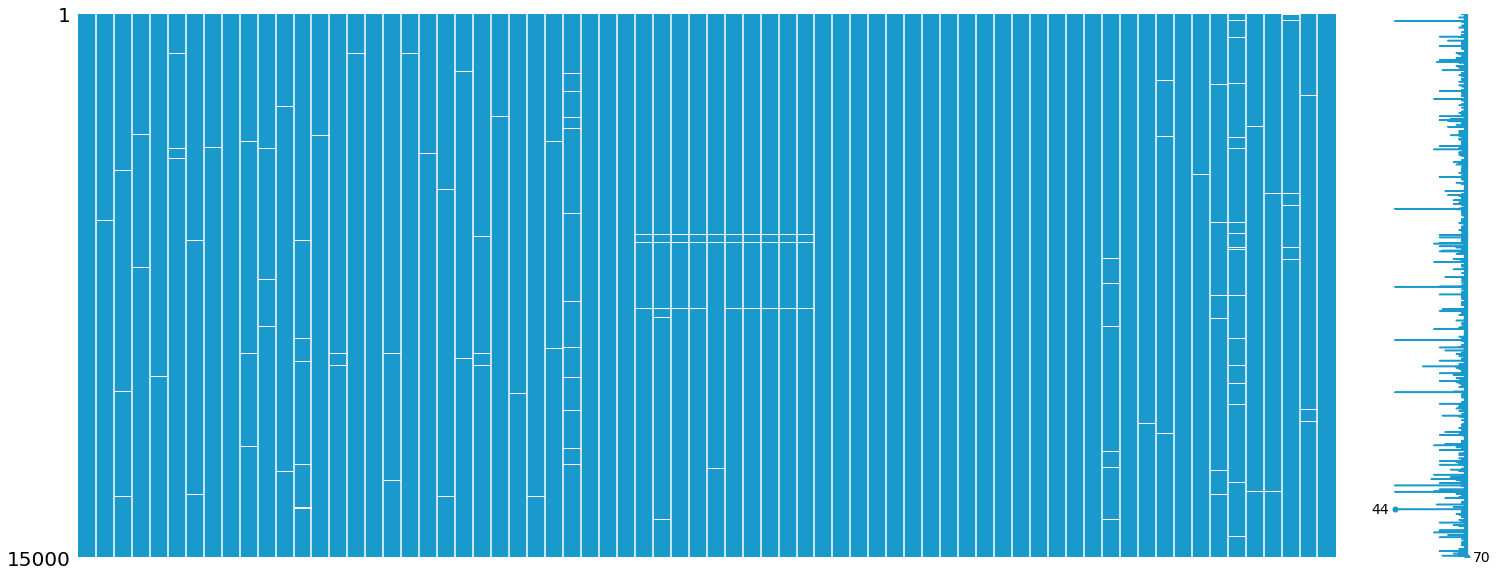

In [3]:
msno.matrix(test.iloc[:, :], color=(0.1, 0.6, 0.8))

# 2. Preprocessing 

In [4]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 

# Feature drop : 'index'
processed_data = test.drop(['index', 'country'], axis=1).copy()

# Handling missing values : 'education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD'
from sklearn.impute import SimpleImputer
fill_cols = ['education', 'gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD']
transformer = SimpleImputer()
processed_data[fill_cols] = transformer.fit_transform(processed_data[fill_cols])
processed_data[fill_cols].describe()

# Log Transformation : 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# Ranging and Ordinary encoding: 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)
oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data['age'].values.reshape(-1,1))

# Handling outlier and iterative imputation : 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)
processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
transformer =  IterativeImputer()
processed_data[['familysize']] = transformer.fit_transform(processed_data[['familysize']])
processed_data['familysize'] = processed_data['familysize'].astype(int)
print(processed_data['familysize'].describe())

count    15000.000000
mean         2.272667
std          0.841091
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: familysize, dtype: float64


<AxesSubplot:>

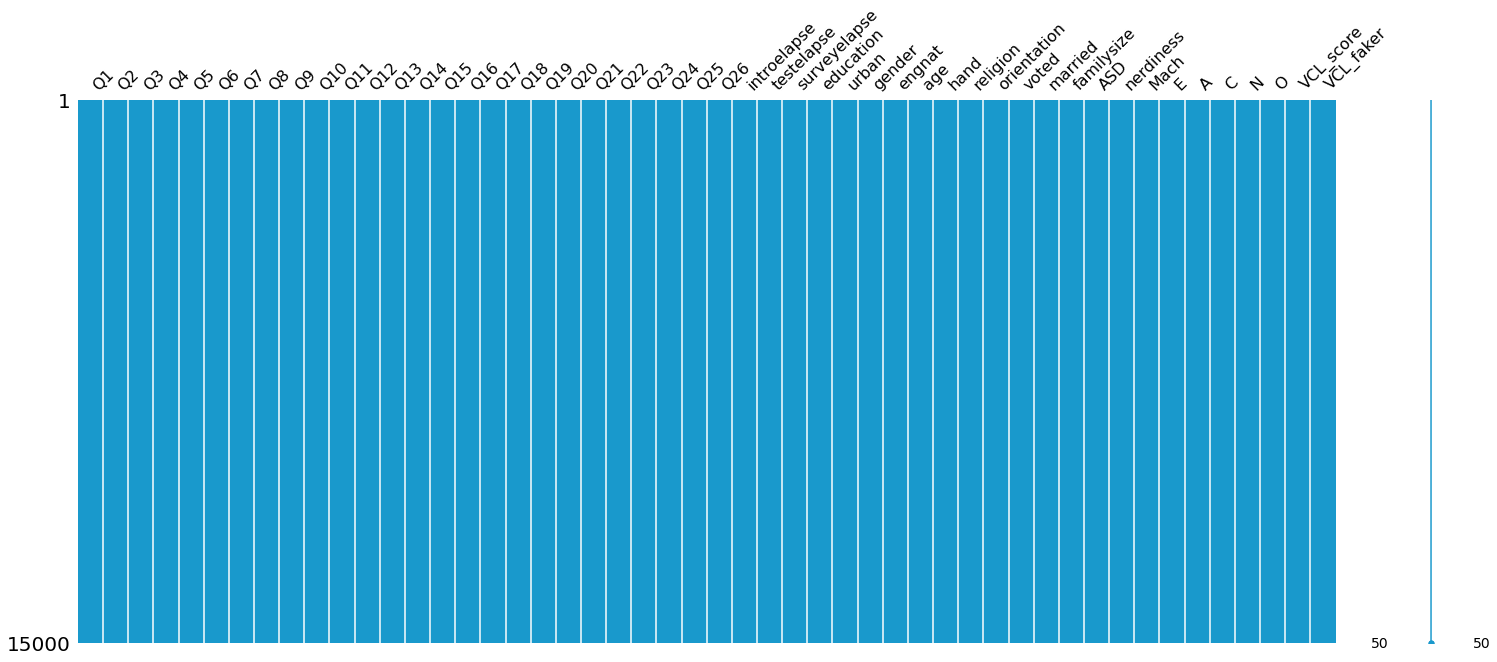

In [5]:
def score_mach(data) :
    rev_cols = ['Q3', 'Q4', 'Q7', 'Q9', 'Q10', 'Q11', 'Q16', 'Q17', 'Q14', 'Q18']
    for flip in rev_cols: 
        data[flip] = 6 - data[flip]
    data['Mach'] = data[mach_cols].mean(axis=1)
    #data.drop(mach_cols, axis=1, inplace = True)
    return data 

def score_tipi(data) :
    data['E'] = (data['TIPI1'] + (8-data['TIPI6'])) / 2
    data['A'] = (data['TIPI7'] + (8-data['TIPI2'])) / 2
    data['C'] = (data['TIPI3'] + (8-data['TIPI8'])) / 2
    data['N'] = (data['TIPI9'] + (8-data['TIPI4'])) / 2
    data['O'] = (data['TIPI5'] + (8-data['TIPI10'])) / 2
    data.drop(['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4', 'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10'], axis=1, inplace = True)
    return data 

def score_vcl(data) :
    data['VCL_score'] = (data['VCL1'] + data['VCL2'] + data['VCL3'] + data['VCL4'] + data['VCL5'] + data['VCL7'] + data['VCL8']
                        + data['VCL10'] + data['VCL11'] + data['VCL13'] + data['VCL14'] + data['VCL15'] + data['VCL16'])
    data['VCL_faker'] = (data['VCL6'] + data['VCL9'] + data['VCL12'])
    data.drop(['VCL1', 'VCL2', 'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 
               'VCL10', 'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16',], axis=1, inplace = True)
    return data 

from sklearn.impute import SimpleImputer
npas_cols = ['Q{}'.format(i) for i in range(1,27)]
tipi_cols = ['TIPI{}'.format(i) for i in range(1,11)]
vcl_cols = ['VCL{}'.format(i) for i in range(1,17)]
mach_cols = ['Q{}'.format(i) for i in range(1,21)]
q_cols = [npas_cols, tipi_cols, vcl_cols]
for col in q_cols : 
    transformer = SimpleImputer()
    processed_data[col] = transformer.fit_transform(processed_data[col])

processed_data = score_mach(processed_data)
processed_data = score_tipi(processed_data)
processed_data = score_vcl(processed_data)

msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

In [6]:
processed_data

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,ASD,nerdiness,Mach,E,A,C,N,O,VCL_score,VCL_faker
0,1.0,5.0,1.0,1.0,1.0,4.0,1.0,5.0,5.0,3.0,...,2.0,1,3.05,3.5,5.0,5.0,6.0,4.0,8.0,0.0
1,4.0,4.0,2.0,2.0,4.0,5.0,2.0,4.0,3.0,3.0,...,2.0,1,3.10,5.0,5.5,5.0,2.5,4.5,11.0,0.0
2,4.0,5.0,1.0,2.0,3.0,5.0,1.0,5.0,2.0,2.0,...,2.0,1,3.00,2.0,4.5,3.5,6.0,5.5,11.0,0.0
3,4.0,4.0,2.0,4.0,4.0,3.0,3.0,5.0,3.0,2.0,...,2.0,1,2.95,4.0,4.5,3.5,3.5,5.0,9.0,0.0
4,4.0,4.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,...,2.0,0,2.95,3.5,4.0,4.0,3.5,5.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.0,5.0,2.0,3.0,3.0,4.0,2.0,4.0,3.0,2.0,...,2.0,0,3.15,2.5,4.5,4.5,4.0,4.0,10.0,1.0
14996,5.0,4.0,1.0,2.0,4.0,5.0,1.0,4.0,2.0,1.0,...,2.0,1,2.80,4.0,5.0,5.5,2.5,5.0,8.0,0.0
14997,4.0,5.0,1.0,1.0,5.0,5.0,1.0,5.0,2.0,1.0,...,1.0,1,3.00,2.0,4.0,3.5,2.0,4.0,9.0,0.0
14998,5.0,5.0,2.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,...,1.0,0,2.65,2.0,6.0,3.5,2.5,5.5,11.0,1.0


In [18]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data_y = input_data['nerdiness'].copy()
input_data_X = input_data.drop(['nerdiness'], axis=1)

# train/ test data 로 split 
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 7,
    shuffle=True
)

test_X_torch = torch.tensor(test_X.to_numpy(), dtype=torch.float32)

# 3. Model Load

In [13]:
from pycaret.classification import *

model_ml = load_model(path+'Pycaret_yesQ_rf_0806_23_22') # you should fill out this part
print(model_ml)

Transformation Pipeline and Model Successfully Loaded
Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['education',
                                                            'urban', 'gender',
                                                            'engnat', 'hand',
                                                            'religion',
                                                            'orientation',
                                                            'voted', 'married',
                                                            'ASD', 'Q1', 'Q2',
                                                            'Q3', 'Q4', 'Q5',
                                                            'Q6', 'Q7', 'Q8',
                                                            'Q9', 'Q10', 'Q11',
                                                            'Q12', 'Q13', 'Q14',
                                                            'Q15',

In [11]:
import torch
from torch import nn

# Layer dim 
n_input_dim = test.shape[1]
n_hidden1 = 294
n_hidden2 = 30
n_output_dim = 1

class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output_dim) 
        
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
    def forward(self, inputs):
        x = self.leakyrelu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.leakyrelu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_nn = torch.load(path+"nn_yesQ_0809_18_18.pt", map_location= device)
print(model_nn)

BinaryClassification(
  (layer_1): Linear(in_features=49, out_features=294, bias=True)
  (layer_2): Linear(in_features=294, out_features=30, bias=True)
  (layer_out): Linear(in_features=30, out_features=1, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(294, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [14]:
pred_ml = predict_model(model_ml, data=test_X)

pred_nn_prob = model(test)
pred_nn_prob = torch.sigmoid(pred_nn_prob)
pred_nn = torch.round(pred_nn_prob)
pred_nn = [a.squeeze().tolist() for a in pred_nn]
pred_nn_prob = [a.squeeze().tolist() for a in pred_nn_prob]
pred_dl = pd.DataFrame([ x for x in zip(pred_nn, pred_nn_prob)])

In [15]:
pred_ml[['Label', 'Score']]

,Label,Score
404,1,0.84
5221,0,0.78
3357,1,0.78
7336,0,0.76
8313,1,0.79
...,...,...
4600,1,0.70
5724,1,0.64
4920,1,0.78
6440,0,0.84


In [19]:
pred_dl

NameError: name 'pred_dl' is not defined

# 4. Ensemble

find out ensemble ratio 

In [20]:
from sklearn.metrics import roc_auc_score, classification_report

In [ ]:
y_pred = (pred_ml + pred_dl) / 2.0 

In [ ]:
roc_auc_score(test_y, )

In [ ]:
print(classification_report(test_y, y_pred_list))